# N-FPN Rock Paper Scissors Toy Problem

We perform a rock-paper-scissors experiment. Each player's actions are restricted to the unit simplex $\Delta^3 \triangleq \{ x \in \mathbb{R}^{3}_{\geq0} : \|x\|_1 = 1\} \subset\mathbb{R}^3$ so that  $\mathcal{C} = \Delta^3 \times \Delta^3$ and actions  $x_i$ are interpreted as probability distributions over  three choices: rock, paper and scissors. 
Equilibria $x_d^\star$ are VI solutions, _i.e._

$$ \left< F(x_d^\star;d), x - x_d^\star\right> \geq 0,\quad \mbox{for all $x\in \mathcal{C}$},$$

using the game gradient 

$$F = [\nabla_{x_1} u_k(x;d)^\top, \ \nabla_{x_2} u_k(x;d)^\top ]^\top $$

with    cost functions given by 
$$
    u_1(x;d) \triangleq \left< x_1, B(d)x_2\right>
    \quad \mbox{and}\quad 
    u_2(x;d) \triangleq -\left< x_1, B(d) x_2\right>.
$$
where the antisymmetric payoff matrix $B(d) \in \mathbb{R}^{3\times 3}$  is defined in the paper is used to define the players' cost functions and each vectors $w^i \in \mathbb{R}^{3}$ is drawn uniformly in $[0,1]^3$ for $i \in [3]$. 
Contextual data $d$ are drawn from a distribution $\mathcal{D}$ that is uniform over $[0,1]^3$. An N-FPN is trained to predict $x_d^\star$ from $d$ using  training data   context-action pairs $\{(d^i,x_{d^i}^\star)\}_{i=1}^{1000}$, without using knowledge of $F$. The learned $F_{\Theta}$ has two fully connected layers with a leaky ReLU activation, and forward propagation uses projected gradient. This notebook generates data for two plots. The first plot shows convergence of the test loss while training the N-FPN.
The final plot simulates play between an optimal Nash player with access to $u_1(\cdot,d)$ and an N-FPN player that only has access to $d$ and training data.
The final plot measures performance using 
\begin{equation}
    \mbox{(Expected Nash Player $k$-Game Cost Variance)} \equiv y^k \triangleq \mathbb{E}_{d\sim\mathcal{D}}\left[\left(\dfrac{1}{k} \sum_{\ell=1}^k  u_1^2\Big(s^\ell; d \Big) \right)^{1/2}\right],
\end{equation}
where $s$ is a tuple of two one-hot vectors $s_1^k \sim x_d^\star$ and $s_2^k \sim \mathcal{N}_\Theta(d)$.
Because rock-paper-scissors is a zero-sum game, if the N-FPN plays optimally, then the average reward of the Nash player converges to zero as the number of games increases.
That is, optimal $\mathcal{N}_\Theta$ yields $y^k\rightarrow 0$, as shown in the final plot of this notebook.

In [1]:
import time
import torch
import torch.nn               as nn
import torch.optim            as optim
import numpy                  as np
import matplotlib.pyplot      as plt
from torch.utils.data         import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

context       = torch.tensor
action        = torch.tensor
weight_matrix = torch.tensor
payoff_matrix = torch.tensor

seed = 30
torch.manual_seed(seed)
W = torch.rand(3, 3) * torch.tensor([0.5, 10, 20])
W = W.permute(1,0)
print(W)

tensor([[ 0.4504,  0.4369,  0.4473],
        [ 7.4636,  7.4026,  6.2383],
        [ 9.4323, 15.6801,  8.5520]])


## Generate Synthetic Training Data


Notes: 

1) The analytic solutions are generated using the Extra Gradient Scheme as in (1.2) and (1.3) of this [paper](http://math.haifa.ac.il/agibali/Web/Extensions%20of%20Korpelevich's%20extragradient%20method%20for%20the%20variational%20inequality%20problem%20in%20Euclidean%20space.pdf).

2) The simplex projection is performed using Algorithm 1 in this [paper](https://arxiv.org/pdf/1309.1541.pdf).

In [2]:
def sample_context(num_samples: int) -> context:
    return torch.rand(num_samples, 3) 


def project_simplex(y: action, action_size=3, num_players=2) -> action:
    num_samples = y.shape[0] 
    proj        = torch.zeros(y.shape)
    for i in range(num_players):
        ind   = [i * action_size + j for j in range(action_size)]
        u     = torch.flip(torch.sort(y[:, ind], dim=1)[0], dims=(1,))
        u_sum = torch.cumsum(u, dim=1)
        j     = torch.arange(1, action_size + 1, dtype=y.dtype, device=y.device)
        pos_u_expr   = u * j + 1.0 - u_sum  > 0 
        pos_u_expr   = pos_u_expr.float() 
        rho          = torch.sum(pos_u_expr, dim=1, keepdim=True)
        rho          = rho.long()
        lambd        = [(1 - u_sum[sample, rho[sample]-1]) / rho[sample] 
                        for sample in range(num_samples)]
        lambd        = torch.tensor(lambd)
        lambd        = lambd.view(lambd.shape[0], 1)
        proj[:, ind] = torch.clamp(y[:, ind] + lambd, min=0)
    return proj


def create_payoff_matrix(d: context) -> payoff_matrix:
    num_samples = d.shape[0] 
    action_size = d.shape[1]
    Wd          = d.mm(W.permute(1,0)) 
    B           = torch.zeros(num_samples, action_size, action_size)
    B[:,0,1]    = -Wd[:, 0]
    B[:,0,2]    =  Wd[:, 1]
    B[:,1,2]    = -Wd[:, 2]
    B          -= B.permute(0, 2, 1)
    return B


def F(x: action, d: context, player_size=3) -> action:
    B    = create_payoff_matrix(d) 
    x    = x.view(x.shape[0], x.shape[1], 1)
    Fx_1 = B.bmm(x[:, player_size:, :])
    Bt   = B.permute(0, 2, 1)
    Fx_2 = -Bt.bmm(x[:, :player_size, :])
    Fx   = torch.cat((Fx_1, Fx_2), dim=1)
    return Fx.view(Fx.shape[0], Fx.shape[1])


def get_nash_eq(d: context, fxd_pt_tol=1e-5, max_iter=10000, step_size=5e-3,
                action_size=6, debug_mode=False) -> action:
    num_samples = d.shape[0]
    x           = torch.rand(num_samples, action_size)
    conv        = False
    step        = 0
    while not conv and step < max_iter:
        x_prev = x.clone()
        y      = project_simplex(x - step_size * F(x, d))
        x      = project_simplex(x - step_size * F(y, d))
        res    = torch.max(torch.norm(x - x_prev, dim=1)) 
        step  += 1
        conv   = res < fxd_pt_tol 
        if step % 5 == 0 and debug_mode:
            fmt_str = "Step {:5d}: |xk - xk_prev| = {:2.2e}   x[0,:] = "
            print(fmt_str.format(step, res) + str(x[0,:]))
    return x


def create_data(train_batch_size=200, test_batch_size=100, 
                train_size=1000,  test_size=100): 
    d_context = sample_context(train_size + test_size)
    x_true    = get_nash_eq(d_context, debug_mode=True)
    dataset   = TensorDataset(x_true, d_context)  

    train_dataset, test_dataset = random_split(dataset, 
                                               [train_size, test_size]) 
    train_loader  = DataLoader(dataset=train_dataset,  
                               batch_size=train_batch_size, shuffle=True) 
    test_loader   = DataLoader(dataset=test_dataset,   
                               batch_size=test_batch_size,  shuffle=False) 
    return train_loader, test_loader


if not 'train_loader' in globals():
    train_loader, test_loader = create_data()

Step     5: |xk - xk_prev| = 1.48e-01   x[0,:] = tensor([0.4481, 0.4214, 0.1305, 0.0943, 0.8389, 0.0668])
Step    10: |xk - xk_prev| = 1.34e-01   x[0,:] = tensor([0.5126, 0.4874, 0.0000, 0.1333, 0.8667, 0.0000])
Step    15: |xk - xk_prev| = 1.08e-01   x[0,:] = tensor([0.5249, 0.4751, 0.0000, 0.1456, 0.8544, 0.0000])
Step    20: |xk - xk_prev| = 8.69e-02   x[0,:] = tensor([0.5371, 0.4629, 0.0000, 0.1579, 0.8421, 0.0000])
Step    25: |xk - xk_prev| = 6.22e-02   x[0,:] = tensor([0.5494, 0.4506, 0.0000, 0.1701, 0.8299, 0.0000])
Step    30: |xk - xk_prev| = 5.13e-02   x[0,:] = tensor([0.5617, 0.4383, 0.0000, 0.1824, 0.8176, 0.0000])
Step    35: |xk - xk_prev| = 4.67e-02   x[0,:] = tensor([0.5739, 0.4261, 0.0000, 0.1947, 0.8053, 0.0000])
Step    40: |xk - xk_prev| = 4.13e-02   x[0,:] = tensor([0.5862, 0.4138, 0.0000, 0.2069, 0.7931, 0.0000])
Step    45: |xk - xk_prev| = 3.42e-02   x[0,:] = tensor([0.5985, 0.4015, 0.0000, 0.2192, 0.7808, 0.0000])
Step    50: |xk - xk_prev| = 3.09e-02   x[0,:]

## Define N-FPN for Rock Paper Scissors

In [3]:
class RPS_Net(nn.Module):
    def __init__(self, action_size=6, context_size=3):
        super(RPS_Net, self).__init__()
        self.fc_1 = nn.Linear(action_size + context_size, 5 * action_size)
        self.fc_2 = nn.Linear(5 * action_size, action_size)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.action_size = action_size


    def device(self) -> str:
        return next(self.parameters()).data.device


    def F(self, x: action, d: context) -> action:
        xd  = torch.cat((x,d), dim=1)
        Fxd = x + self.fc_2(self.leaky_relu(self.fc_1(xd))) 
        return Fxd


    def project_simplex(self, y: action, action_size=3, num_players=2) -> action:
        num_samples = y.shape[0] 
        proj        = torch.zeros(y.shape)
        for i in range(num_players):
            ind   = [i * action_size + j for j in range(action_size)]
            u     = torch.flip(torch.sort(y[:, ind], dim=1)[0], dims=(1,))
            u_sum = torch.cumsum(u, dim=1)
            j     = torch.arange(1, action_size + 1, dtype=y.dtype, device=y.device)
            pos_u_expr   = u * j + 1.0 - u_sum  > 0 
            pos_u_expr   = pos_u_expr.float() 
            rho          = torch.sum(pos_u_expr, dim=1, keepdim=True)
            rho          = rho.long()
            lambd        = [(1 - u_sum[sample, rho[sample]-1]) / rho[sample] 
                            for sample in range(num_samples)]
            lambd        = torch.tensor(lambd)
            lambd        = lambd.view(lambd.shape[0], 1)
            proj[:, ind] = torch.clamp(y[:, ind] + lambd, min=0)
        return proj


    def forward(self, d: context, fxd_pt_tol=1.0e-5, max_depth=100, 
                depth_warning=False) -> action: 

        with torch.no_grad():
            self.depth = 0.0
            x = torch.zeros((d.shape[0], self.action_size), device=self.device())
            x_prev = np.Inf * torch.ones(x.shape, device=self.device())            
            all_samp_conv = False
            while not all_samp_conv and self.depth < max_depth:
                x_prev        = x.clone()   
                x             = self.project_simplex(x - self.F(x,d))
                res_norm      = torch.max(torch.norm(x - x_prev, dim=1)) 
                self.depth   += 1.0
                all_samp_conv = res_norm <= fxd_pt_tol
            
        if self.depth >= max_depth and depth_warning:
            print("\nWarning: Max Depth Reached - Break Forward Loop\n")

        attach_gradients = self.training
        return self.project_simplex(x - self.F(x,d)) if attach_gradients else x

## Create Training Setup

In [4]:
model         = RPS_Net()
learning_rate = 1e-3
optimizer     = optim.Adam(model.parameters(), lr=learning_rate)
fxd_pt_tol    = 1.0e-6  
criterion     = nn.MSELoss()
max_epochs    = 1000 
save_str      = 'NFPN_RPS_data.pth'

def num_params(model):
    num_params = 0
    for name, parameter in model.named_parameters():
        num_params += parameter.numel()
    return num_params

print("Trainable Parameters: ", num_params(model))
print(model)

Trainable Parameters:  486
RPS_Net(
  (fc_1): Linear(in_features=9, out_features=30, bias=True)
  (fc_2): Linear(in_features=30, out_features=6, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
)


## Train the Network

In [5]:
test_loss_hist  = []  
train_loss_hist = [] 
depth_hist      = [] 
train_loss_ave  = 0

fmt  = '[{:4d}/{:4d}]: train loss = {:7.3e} | test_loss = {:7.3e} | depth ' 
fmt += '= {:5.1f} | lr = {:5.1e} | fxt_pt_tol = {:5.1e} | time = {:4.1f} sec' 
print('\nTraining Fixed Point Network')

for epoch in range(max_epochs): 
    start_time = time.time()
    for x_batch, d_batch in train_loader:  
        model.train()
        optimizer.zero_grad()
        x_pred = model(d_batch, fxd_pt_tol=fxd_pt_tol) 
        loss   = criterion(x_pred, x_batch)
        train_loss_ave = 0.95 * train_loss_ave + 0.05 * loss.item()
        loss.backward()
        optimizer.step()  

    for x_batch, d_batch in test_loader:
        with torch.no_grad():
            x_pred    = model(d_batch, fxd_pt_tol=fxd_pt_tol)   
            test_loss = criterion(x_pred, x_batch)
    
    time_epoch = time.time() - start_time

    print(fmt.format(epoch+1, max_epochs, train_loss_ave, test_loss.item(), 
                     model.depth, optimizer.param_groups[0]['lr'], fxd_pt_tol, 
                     time_epoch))
    
    test_loss_hist.append(test_loss.item())
    train_loss_hist.append(loss.item())
    depth_hist.append(model.depth)

    if epoch % 10 == 0 or epoch == max_epochs-1:
        state = {
        'fxd_pt_tol': fxd_pt_tol,
        'T_state_dict': model.state_dict(),
        'test_loss_hist': test_loss_hist,
        'train_loss_hist': train_loss_hist,
        'depth_hist': depth_hist
        }
        torch.save(state, save_str)


Training Fixed Point Network
[   1/1000]: train loss = 8.473e-03 | test_loss = 3.118e-02 | depth =  13.0 | lr = 1.0e-03 | fxt_pt_tol = 1.0e-06 | time =  1.0 sec
[   2/1000]: train loss = 1.275e-02 | test_loss = 2.256e-02 | depth =  13.0 | lr = 1.0e-03 | fxt_pt_tol = 1.0e-06 | time =  0.8 sec
[   3/1000]: train loss = 1.429e-02 | test_loss = 1.587e-02 | depth =  13.0 | lr = 1.0e-03 | fxt_pt_tol = 1.0e-06 | time =  0.8 sec
[   4/1000]: train loss = 1.413e-02 | test_loss = 1.077e-02 | depth =  13.0 | lr = 1.0e-03 | fxt_pt_tol = 1.0e-06 | time =  0.8 sec
[   5/1000]: train loss = 1.299e-02 | test_loss = 6.964e-03 | depth =  13.0 | lr = 1.0e-03 | fxt_pt_tol = 1.0e-06 | time =  0.9 sec
[   6/1000]: train loss = 1.136e-02 | test_loss = 4.261e-03 | depth =  13.0 | lr = 1.0e-03 | fxt_pt_tol = 1.0e-06 | time =  1.1 sec
[   7/1000]: train loss = 9.587e-03 | test_loss = 2.497e-03 | depth =  13.0 | lr = 1.0e-03 | fxt_pt_tol = 1.0e-06 | time =  0.8 sec
[   8/1000]: train loss = 7.895e-03 | test_los

## Plot Convergence of Test Loss

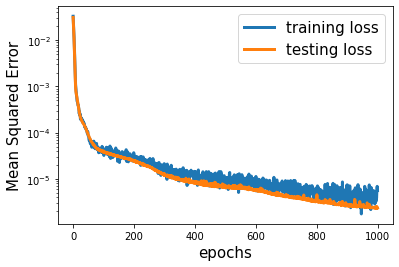

In [6]:
import matplotlib.pyplot as plt

fig1 = plt.figure(1)
plt.plot(train_loss_hist, linewidth=3)
plt.plot(test_loss_hist, linewidth=3)
plt.yscale('log')
plt.legend(['training loss', 'testing loss'], fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.savefig('N_FPN_RPS_test_loss.pdf')


filename = 'N_FPN_RPS_test_loss.csv'
with open(filename, 'w') as f: 
  for epoch, loss in enumerate(test_loss_hist):     
    f.write('%0.5e,%0.5e\n' % (epoch + 1, loss)) 

## Simulate Play of N-FPN Against Selfish Player

Here we pit two players against each other. 

Case 1:
* Nash Player 1 knows the context $d$ and payoff matrix $B(d)$
* N-FPN Player 2 knows the context $d$ and historical observations (training data)


Case 2:
* Nash Player 1 knows the context $d$ and payoff matrix $B(d)$
* Nash Player 2 knows the context $d$ and payoff matrix $B(d)$


Each player's action profile is on the simplex. Each round of play is executed by sampling each player's decision ("rock", "paper", or "scissors") according to their action profile. We then plot the average reward of Player 2 over time. If the N-FPN is "good", then the average reward of each player will eventually converge to 0 (since rock-paper-scissors is a zero sum game).

Playing Games for Context  1 of 50
Playing Games for Context  2 of 50
Playing Games for Context  3 of 50
Playing Games for Context  4 of 50
Playing Games for Context  5 of 50
Playing Games for Context  6 of 50
Playing Games for Context  7 of 50
Playing Games for Context  8 of 50
Playing Games for Context  9 of 50
Playing Games for Context 10 of 50
Playing Games for Context 11 of 50
Playing Games for Context 12 of 50
Playing Games for Context 13 of 50
Playing Games for Context 14 of 50
Playing Games for Context 15 of 50
Playing Games for Context 16 of 50
Playing Games for Context 17 of 50
Playing Games for Context 18 of 50
Playing Games for Context 19 of 50
Playing Games for Context 20 of 50
Playing Games for Context 21 of 50
Playing Games for Context 22 of 50
Playing Games for Context 23 of 50
Playing Games for Context 24 of 50
Playing Games for Context 25 of 50
Playing Games for Context 26 of 50
Playing Games for Context 27 of 50
Playing Games for Context 28 of 50
Playing Games for Co

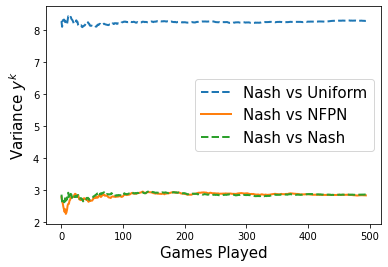

In [7]:
def sample_distribution(prob_vec) -> action:
    '''Sample from a discrete probability distribution

       Create a cumulative distribution vector and sample a point p uniformly
       from [0,1]. Then p will have a value between two of the cumulative
       entries, which indicates the sample index to pick for the sampling.
    '''
    p_sample      = torch.rand(1) 
    dist_vec      = torch.cumsum(prob_vec, dim=0)
    action_sample = torch.zeros(prob_vec.shape)
    for idx, ref in enumerate(dist_vec):
        if ref > p_sample: 
            action_sample[idx] = 1.0
            return action_sample
    print("Error: Unable to assign action")

num_games   = 500
player_size = 3
num_samples = 50
rewards_nash_nfpn = torch.zeros(num_samples, num_games)
rewards_nash_nash = torch.zeros(num_samples, num_games)
rewards_nash_unif = torch.zeros(num_samples, num_games)
x_uniform         = torch.tensor([1.0/3, 1.0/3, 1.0/3])

for context in range(num_samples):
    print("Playing Games for Context {:2d} of {:2d}".format(context + 1, 
                                                            num_samples))
    d_sample = sample_context(num_samples=1)
    Bd       = create_payoff_matrix(d_sample)
    x_nash   = get_nash_eq(d_sample) 
    x_nfpn   = model(d_sample)
    for idx in range(num_games):
        action_nash1 = sample_distribution(x_nash[0, :player_size])
        action_nash1 = action_nash1.view(1, player_size, 1)
        action_nash2 = sample_distribution(x_nash[0, player_size:])
        action_nash2 = action_nash2.view(1, player_size, 1)       
        action_nfpn  = sample_distribution(x_nfpn[0, player_size:])
        action_nfpn  = action_nfpn.view(1, player_size, 1)
        action_unif  = sample_distribution(x_uniform)
        action_unif  = action_unif.view(1, player_size, 1)        
        Bd_nfpn      = torch.bmm(Bd, action_nfpn)
        Bd_nash2     = torch.bmm(Bd, action_nash2)
        Bd_unif      = torch.bmm(Bd, action_unif)    
        reward_nash_nfpn = torch.bmm(action_nash1.permute(0, 2, 1), Bd_nfpn)[0,0,0]
        reward_nash_nash = torch.bmm(action_nash1.permute(0, 2, 1), Bd_nash2)[0,0,0]
        reward_nash_unif = torch.bmm(action_nash1.permute(0, 2, 1), Bd_unif)[0,0,0]
        rewards_nash_nfpn[context, idx] = (reward_nash_nfpn)
        rewards_nash_nash[context, idx] = (reward_nash_nash)
        rewards_nash_unif[context, idx] = (reward_nash_unif) 

lin_space    = torch.cumsum(torch.ones(rewards_nash_nfpn.shape), dim=1) 
nash_vs_nfpn = torch.mean(rewards_nash_nfpn ** 2, dim=0, keepdim=True) ** 0.5
nash_vs_nfpn = torch.cumsum(nash_vs_nfpn, dim=1) / lin_space
nash_vs_nash = torch.mean(rewards_nash_nash ** 2, dim=0, keepdim=True) ** 0.5
nash_vs_nash = torch.cumsum(nash_vs_nash, dim=1) / lin_space
nash_vs_unif = torch.mean(rewards_nash_unif ** 2, dim=0, keepdim=True) ** 0.5
nash_vs_unif = torch.cumsum(nash_vs_unif, dim=1) / lin_space

fig1 = plt.figure(1)
plt.plot(nash_vs_unif[0,5:], '--', linewidth=2) 
plt.plot(nash_vs_nfpn[0,5:], linewidth=2)
plt.plot(nash_vs_nash[0,5:],  '--', linewidth=2) 
plt.legend(['Nash vs Uniform', 'Nash vs NFPN', 'Nash vs Nash'], fontsize=15)
plt.xlabel('Games Played', fontsize=15)
plt.ylabel('Variance $y^k$', fontsize=15)
plt.savefig('N_FPN_RPS_nash_reward.pdf') 

filename = 'N_FPN_RPS_nash_vs_nfpn.csv'
with open(filename, 'w') as f: 
  for game, cost in enumerate(nash_vs_nfpn[0, :]):     
    f.write('%0.5e,%0.5e\n' % (game + 1, cost)) 

filename = 'N_FPN_RPS_nash_vs_nash.csv'
with open(filename, 'w') as f: 
  for game, cost in enumerate(nash_vs_nash[0, :]):     
    f.write('%0.5e,%0.5e\n' % (game + 1, cost))    

filename = 'N_FPN_RPS_nash_vs_unif.csv'
with open(filename, 'w') as f: 
  for game, cost in enumerate(nash_vs_unif[0, :]):     
    f.write('%0.5e,%0.5e\n' % (game + 1, cost))       